**Original LR Model**

In [1]:
# Main dataset regression (without deduce 0 variance variables)

import pandas as pd
import statsmodels.api as sm

# Load the dataset
final_dataset = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv')

blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']

# Set 1 for blue states and 0 for others
final_dataset['blue_states'] = final_dataset['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)

# Set 1 for red states and 0 for others
final_dataset['red_states'] = final_dataset['location_key'].apply(lambda x: 1 if x in red_states_list else 0)

# US_AZ, US_NV, US_FL, US_NC, US_GA, US_OH, US_MI, US_PA, US_MN, US_WI
# Set 1 for swing states and 0 for others
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']
final_dataset['swing_states'] = final_dataset['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Define the dependent variable
Y = final_dataset['inc cases']

# List of selected variables (assumed after location_key dummies are created)
selected_variables = [
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold', 
] + ['blue_states', 'red_states', 'swing_states']  # This includes all dummy variables for location_key

# Fill missing values for the selected numerical columns
for column in selected_variables:
    if column in final_dataset and final_dataset[column].dtype != 'object':
        final_dataset[column].fillna(final_dataset[column].mean(), inplace=True)
        
# Define X with selected variables including dummy variables
X = final_dataset[selected_variables]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Ensure 'y' is numeric and handle missing values
Y = pd.to_numeric(Y, errors='coerce').fillna(Y.mean())

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              inc cases   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1645.
Date:                Sun, 26 May 2024   Prob (F-statistic):               0.00
Time:                        19:37:20   Log-Likelihood:                -68821.
No. Observations:                6104   AIC:                         1.377e+05
Df Residuals:                    6095   BIC:                         1.377e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

**Improved Model with Absolute Population Indicator**

                            OLS Regression Results                            
Dep. Variable:              inc cases   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     810.6
Date:                Sun, 26 May 2024   Prob (F-statistic):               0.00
Time:                        19:37:20   Log-Likelihood:                -31624.
No. Observations:                2760   AIC:                         6.327e+04
Df Residuals:                    2751   BIC:                         6.332e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


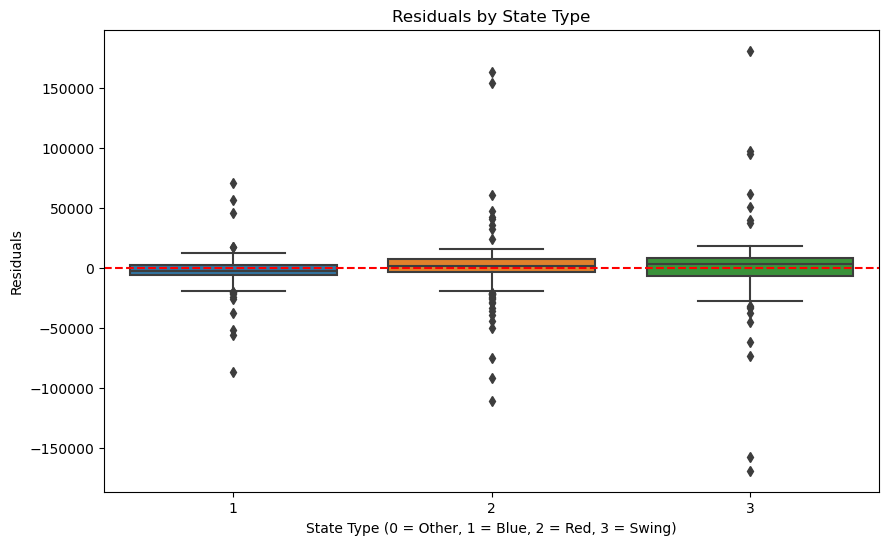

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv('processed_data/weekly_data_unemployment.csv', low_memory=False)

territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']

df = df[~df['location_key'].isin(territories_to_exclude)]

# Define state lists
blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Select predictors and target variable before dropping missing values
X = df[['inc cases', 'location_key', 'new_hospitalized_patients', 'new_persons_fully_vaccinated', 'stringency_index', 'average_temperature_celsius', 'search_trends_common_cold', 'unemployment_rate', 'blue_states', 'red_states', 'swing_states']]

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')

# Separate predictors and target variable after cleaning
y_cleaned = data_cleaned['inc cases']
X_cleaned = data_cleaned.drop(columns=['inc cases'])

# Drop the location_key column as we are using dummy variables for state types instead
X_cleaned = X_cleaned.drop(columns=['location_key'])

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_cleaned)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_cleaned.iloc[:, selector.get_support(indices=True)]

# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

# Standardise features to help with interpretation 
scaler = StandardScaler()
scaler.fit(X_encoded_final)
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_cleaned, test_size=0.2, random_state=42)

# Adding a constant for the intercept
X_train_with_const = sm.add_constant(X_train)

# Fitting the linear regression model
model = sm.OLS(y_train, X_train_with_const).fit()

# Displaying the regression results
print(model.summary())

# Perform cross-validation to ensure consistency of the model
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Evaluate the model on the test set
X_test_with_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_const)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Analyze residuals
residuals = y_test - y_pred
results_df = pd.DataFrame({'Residuals': residuals, 'State_Type': df.loc[y_test.index, 'blue_states'] + df.loc[y_test.index, 'red_states']*2 + df.loc[y_test.index, 'swing_states']*3})

plt.figure(figsize=(10, 6))
sns.boxplot(x='State_Type', y='Residuals', data=results_df)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('State Type (0 = Other, 1 = Blue, 2 = Red, 3 = Swing)')
plt.ylabel('Residuals')
plt.title('Residuals by State Type')
plt.show()

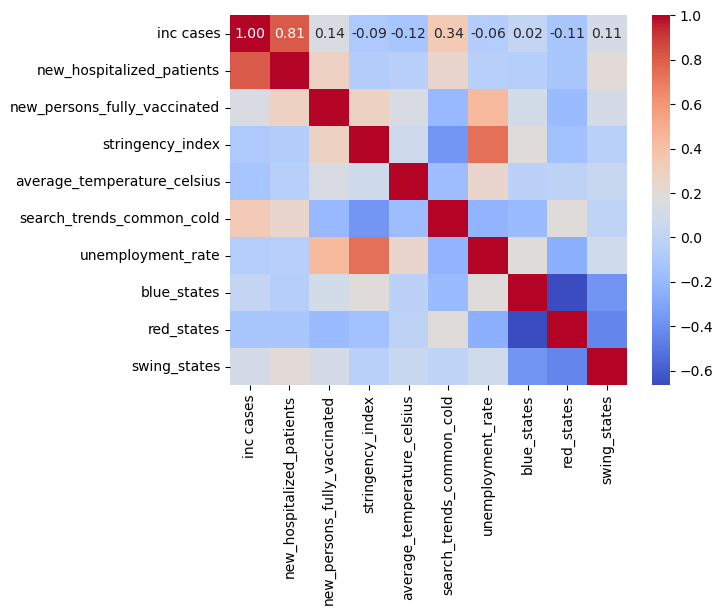

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_X = X.loc[:, ~X.columns.str.startswith('location_key')]
filtered_X = filtered_X.loc[:, filtered_X.std() > 0]
corr = filtered_X.corr()

# heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

RMSE for Blue States: 12622.0489
RMSE for Red States: 19865.6134
RMSE for Swing States: 30830.0587


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


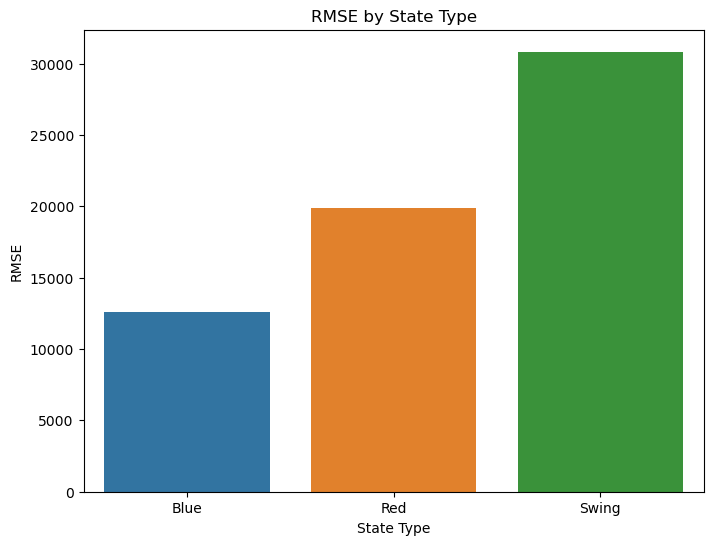

In [4]:
# Evaluate the model on the test set by state type
y_test_blue = y_test[df.loc[y_test.index, 'blue_states'] == 1]
y_test_red = y_test[df.loc[y_test.index, 'red_states'] == 1]
y_test_swing = y_test[df.loc[y_test.index, 'swing_states'] == 1]

X_test_blue = X_test_with_const[df.loc[y_test.index, 'blue_states'] == 1]
X_test_red = X_test_with_const[df.loc[y_test.index, 'red_states'] == 1]
X_test_swing = X_test_with_const[df.loc[y_test.index, 'swing_states'] == 1]

y_pred_blue = model.predict(X_test_blue)
y_pred_red = model.predict(X_test_red)
y_pred_swing = model.predict(X_test_swing)

rmse_blue = np.sqrt(mean_squared_error(y_test_blue, y_pred_blue))
rmse_red = np.sqrt(mean_squared_error(y_test_red, y_pred_red))
rmse_swing = np.sqrt(mean_squared_error(y_test_swing, y_pred_swing))

print(f'RMSE for Blue States: {rmse_blue:.4f}')
print(f'RMSE for Red States: {rmse_red:.4f}')
print(f'RMSE for Swing States: {rmse_swing:.4f}')

# You can also plot these RMSE values for better visualization
rmse_values = pd.DataFrame({
    'State Type': ['Blue', 'Red', 'Swing'],
    'RMSE': [rmse_blue, rmse_red, rmse_swing]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_values)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

**Population Correction**

In [5]:
import pandas as pd

population = pd.read_csv('raw_datasets\population\population_cleaned.csv', low_memory=False)

def clean_and_convert(value):
    return int(value.replace(',', ''))

for year in ['2020', '2021', '2022', '2023']:
    population[year] = population[year].apply(clean_and_convert)

population.head()

,location,location_key,2020,2021,2022,2023
0,United States,US,331526933,332048977,333271411,334914895
1,Northeast,NaN,57430477,57243423,57026847,56983517
2,Midwest,NaN,68969794,68850246,68783028,68909283
3,South,NaN,126465281,127353282,128702030,130125290
4,West,NaN,78661381,78602026,78759506,78896805


In [6]:
df = pd.read_csv('processed_data/weekly_data_unemployment.csv', low_memory=False)

df.head()

,target_end_date,location_key,search_trends_common_cold,new_hospitalized_patients,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,unemployment_rate
0,2020-04-11,US_WA,14.744286,0.0,79.630000,NaN,10.089947,2728.0,16.7
1,2020-04-11,US_AZ,16.530000,326.0,64.418571,NaN,14.730159,1374.0,13.8
2,2020-04-11,US_ID,16.725714,66.0,87.960000,NaN,6.176367,362.0,11.8
3,2020-04-11,US_RI,17.327143,0.0,82.410000,NaN,8.069665,1543.0,17.9
4,2020-04-11,US_CT,17.478571,0.0,78.700000,NaN,9.071429,6234.0,8.3


In [7]:
# Extract year from target_end_date
df['year'] = pd.to_datetime(df['target_end_date']).dt.year.astype(str)

# Melt the population dataframe to long format
population_long = pd.melt(population, id_vars=['location', 'location_key'], var_name='year', value_name='total_population')

# Merge datasets on location_key and year
df = df.merge(population_long, on=['location_key', 'year'], how='left')

df.head()

,target_end_date,location_key,search_trends_common_cold,new_hospitalized_patients,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,unemployment_rate,year,location,total_population
0,2020-04-11,US_WA,14.744286,0.0,79.630000,NaN,10.089947,2728.0,16.7,2020,Washington,7724566.0
1,2020-04-11,US_AZ,16.530000,326.0,64.418571,NaN,14.730159,1374.0,13.8,2020,Arizona,7186683.0
2,2020-04-11,US_ID,16.725714,66.0,87.960000,NaN,6.176367,362.0,11.8,2020,Idaho,1849339.0
3,2020-04-11,US_RI,17.327143,0.0,82.410000,NaN,8.069665,1543.0,17.9,2020,Rhode Island,1096444.0
4,2020-04-11,US_CT,17.478571,0.0,78.700000,NaN,9.071429,6234.0,8.3,2020,Connecticut,3577586.0


In [8]:
df['hospitalized_per_100k'] = (df['new_hospitalized_patients'] / df['total_population']) * 100000
df['cases_per_100k'] = (df['inc cases'] / df['total_population']) * 100000
df['vaccinated_per_100k'] = (df['new_persons_fully_vaccinated'] / df['total_population']) * 100000

df.head()

,target_end_date,location_key,search_trends_common_cold,new_hospitalized_patients,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,unemployment_rate,year,location,total_population,hospitalized_per_100k,cases_per_100k,vaccinated_per_100k
0,2020-04-11,US_WA,14.744286,0.0,79.630000,NaN,10.089947,2728.0,16.7,2020,Washington,7724566.0,0.000000,35.315900,NaN
1,2020-04-11,US_AZ,16.530000,326.0,64.418571,NaN,14.730159,1374.0,13.8,2020,Arizona,7186683.0,4.536168,19.118695,NaN
2,2020-04-11,US_ID,16.725714,66.0,87.960000,NaN,6.176367,362.0,11.8,2020,Idaho,1849339.0,3.568843,19.574562,NaN
3,2020-04-11,US_RI,17.327143,0.0,82.410000,NaN,8.069665,1543.0,17.9,2020,Rhode Island,1096444.0,0.000000,140.727661,NaN
4,2020-04-11,US_CT,17.478571,0.0,78.700000,NaN,9.071429,6234.0,8.3,2020,Connecticut,3577586.0,0.000000,174.251576,NaN


In [9]:
df.to_csv('processed_data/100k_population_data.csv', index=False)

                            OLS Regression Results                            
Dep. Variable:         cases_per_100k   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     325.6
Date:                Sun, 26 May 2024   Prob (F-statistic):          4.14e-316
Time:                        19:37:21   Log-Likelihood:                -19416.
No. Observations:                2760   AIC:                         3.885e+04
Df Residuals:                    2753   BIC:                         3.889e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


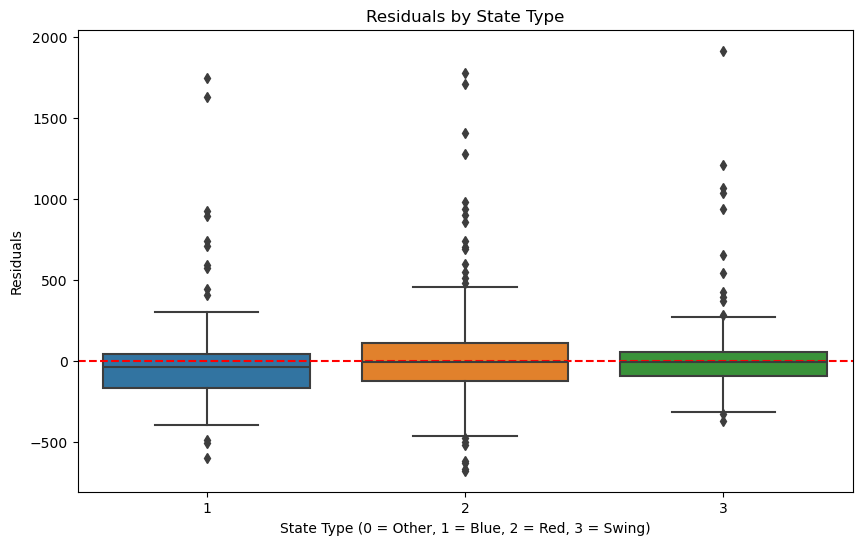

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']

df = df[~df['location_key'].isin(territories_to_exclude)]

# Define state lists
blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Select predictors and target variable before dropping missing values
X = df[['cases_per_100k', 'location_key', 'vaccinated_per_100k', 'stringency_index', 'average_temperature_celsius', 'search_trends_common_cold', 'blue_states', 'red_states', 'swing_states']]

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')

# Separate predictors and target variable after cleaning
y_cleaned = data_cleaned['cases_per_100k']
X_cleaned = data_cleaned.drop(columns=['cases_per_100k'])

# Drop the location_key column as we are using dummy variables for state types instead
X_cleaned = X_cleaned.drop(columns=['location_key'])

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_cleaned)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_cleaned.iloc[:, selector.get_support(indices=True)]

# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

# Standardise features to help with interpretation 
scaler = StandardScaler()
scaler.fit(X_encoded_final)
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_cleaned, test_size=0.2, random_state=42)

# Adding a constant for the intercept
X_train_with_const = sm.add_constant(X_train)

# Fitting the linear regression model
model = sm.OLS(y_train, X_train_with_const).fit()

# Displaying the regression results
print(model.summary())

# Perform cross-validation to ensure consistency of the model
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Evaluate the model on the test set
X_test_with_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_const)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Analyze residuals
residuals = y_test - y_pred
results_df = pd.DataFrame({'Residuals': residuals, 'State_Type': df.loc[y_test.index, 'blue_states'] + df.loc[y_test.index, 'red_states']*2 + df.loc[y_test.index, 'swing_states']*3})

plt.figure(figsize=(10, 6))
sns.boxplot(x='State_Type', y='Residuals', data=results_df)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('State Type (0 = Other, 1 = Blue, 2 = Red, 3 = Swing)')
plt.ylabel('Residuals')
plt.title('Residuals by State Type')
plt.show()

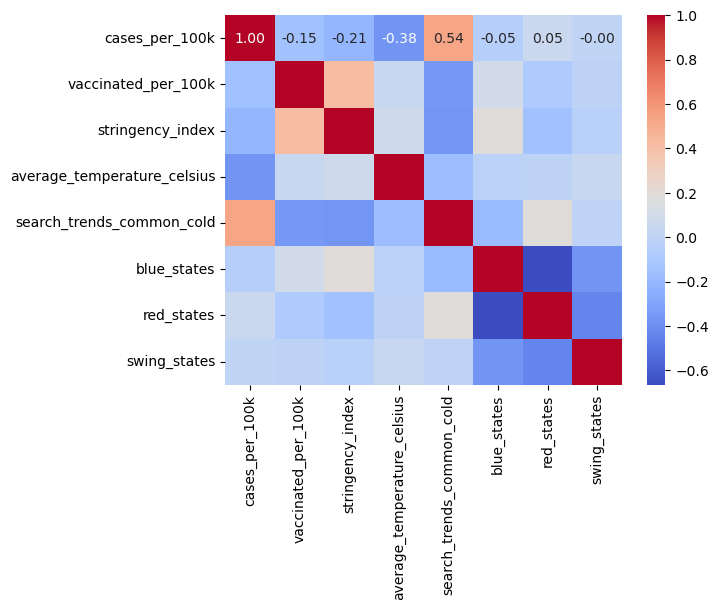

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_X = X.loc[:, ~X.columns.str.startswith('location_key')]
filtered_X = filtered_X.loc[:, filtered_X.std() > 0]
corr = filtered_X.corr()

# heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

RMSE for Blue States: 256.6780
RMSE for Red States: 299.4929
RMSE for Swing States: 281.3021


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


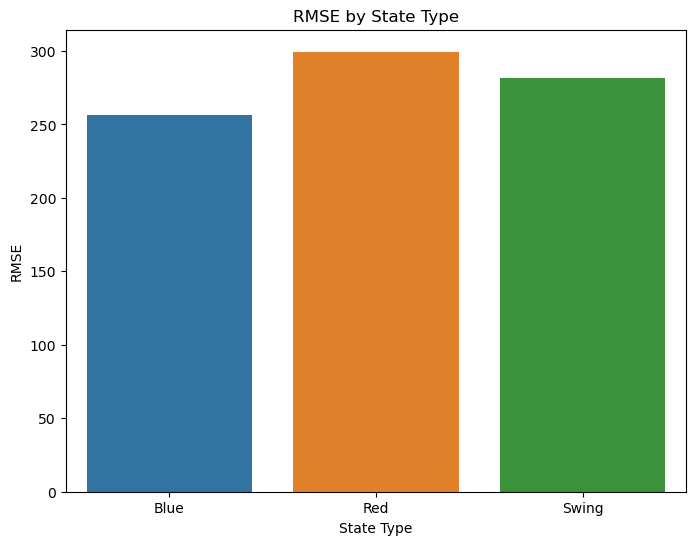

In [12]:
# Evaluate the model on the test set by state type
y_test_blue = y_test[df.loc[y_test.index, 'blue_states'] == 1]
y_test_red = y_test[df.loc[y_test.index, 'red_states'] == 1]
y_test_swing = y_test[df.loc[y_test.index, 'swing_states'] == 1]

X_test_blue = X_test_with_const[df.loc[y_test.index, 'blue_states'] == 1]
X_test_red = X_test_with_const[df.loc[y_test.index, 'red_states'] == 1]
X_test_swing = X_test_with_const[df.loc[y_test.index, 'swing_states'] == 1]

y_pred_blue = model.predict(X_test_blue)
y_pred_red = model.predict(X_test_red)
y_pred_swing = model.predict(X_test_swing)

rmse_blue = np.sqrt(mean_squared_error(y_test_blue, y_pred_blue))
rmse_red = np.sqrt(mean_squared_error(y_test_red, y_pred_red))
rmse_swing = np.sqrt(mean_squared_error(y_test_swing, y_pred_swing))

print(f'RMSE for Blue States: {rmse_blue:.4f}')
print(f'RMSE for Red States: {rmse_red:.4f}')
print(f'RMSE for Swing States: {rmse_swing:.4f}')

# You can also plot these RMSE values for better visualization
rmse_values = pd.DataFrame({
    'State Type': ['Blue', 'Red', 'Swing'],
    'RMSE': [rmse_blue, rmse_red, rmse_swing]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_values)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

**Apply Cook PVI**

In [13]:
import pandas as pd

pvi = pd.read_csv('raw_datasets/cook_pvi/blue-states-2024.csv', low_memory=False)

def classify_state(pvi):
    if pvi >= 5:
        return 'Red State'
    elif pvi <= -5:
        return 'Blue State'
    else:
        return 'Swing State'

# Apply classification function
pvi['classification'] = pvi['BlueStatesPvi2023'].apply(classify_state)

# Generate lists of state abbreviations
red_states = pvi[pvi['classification'] == 'Red State']['state'].tolist()
blue_states = pvi[pvi['classification'] == 'Blue State']['state'].tolist()
swing_states = pvi[pvi['classification'] == 'Swing State']['state'].tolist()

# Convert state names to US_XX format
state_abbr = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

red_states_list = ['US_' + state_abbr[state] for state in red_states]
blue_states_list = ['US_' + state_abbr[state] for state in blue_states]
swing_states_list = ['US_' + state_abbr[state] for state in swing_states]

                            OLS Regression Results                            
Dep. Variable:         cases_per_100k   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     323.9
Date:                Sun, 26 May 2024   Prob (F-statistic):          9.08e-315
Time:                        19:37:22   Log-Likelihood:                -19420.
No. Observations:                2760   AIC:                         3.885e+04
Df Residuals:                    2753   BIC:                         3.889e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


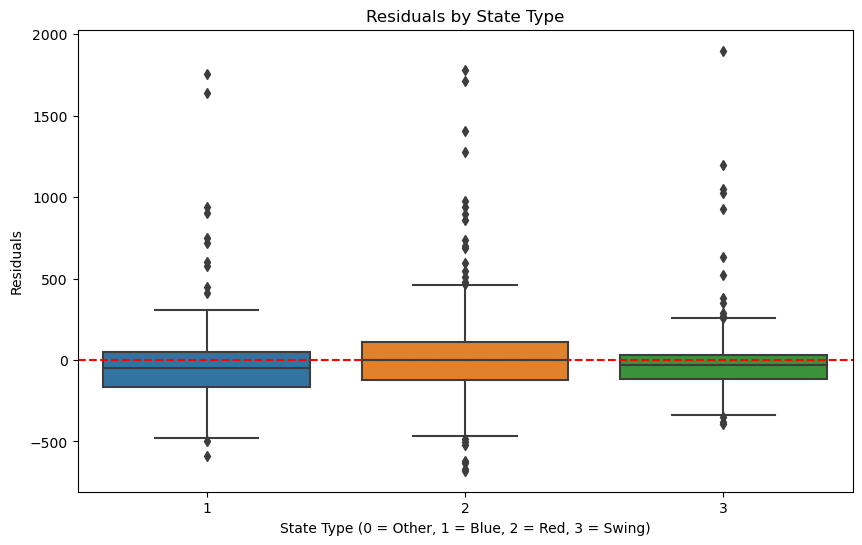

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']

df = df[~df['location_key'].isin(territories_to_exclude)]

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Select predictors and target variable before dropping missing values
X = df[['cases_per_100k', 'location_key', 'vaccinated_per_100k', 'stringency_index', 'average_temperature_celsius', 'search_trends_common_cold', 'blue_states', 'red_states', 'swing_states']]

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')

# Separate predictors and target variable after cleaning
y_cleaned = data_cleaned['cases_per_100k']
X_cleaned = data_cleaned.drop(columns=['cases_per_100k'])

# Drop the location_key column as we are using dummy variables for state types instead
X_cleaned = X_cleaned.drop(columns=['location_key'])

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_cleaned)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_cleaned.iloc[:, selector.get_support(indices=True)]

# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

# Standardise features to help with interpretation 
scaler = StandardScaler()
scaler.fit(X_encoded_final)
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_cleaned, test_size=0.2, random_state=42)

# Adding a constant for the intercept
X_train_with_const = sm.add_constant(X_train)

# Fitting the linear regression model
model = sm.OLS(y_train, X_train_with_const).fit()

# Displaying the regression results
print(model.summary())

# Perform cross-validation to ensure consistency of the model
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Evaluate the model on the test set
X_test_with_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_const)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Analyze residuals
residuals = y_test - y_pred
results_df = pd.DataFrame({'Residuals': residuals, 'State_Type': df.loc[y_test.index, 'blue_states'] + df.loc[y_test.index, 'red_states']*2 + df.loc[y_test.index, 'swing_states']*3})

plt.figure(figsize=(10, 6))
sns.boxplot(x='State_Type', y='Residuals', data=results_df)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('State Type (0 = Other, 1 = Blue, 2 = Red, 3 = Swing)')
plt.ylabel('Residuals')
plt.title('Residuals by State Type')
plt.show()

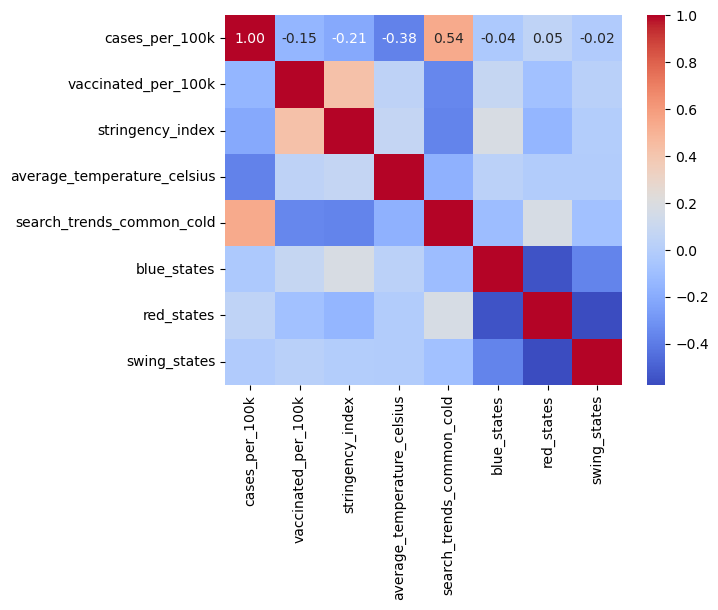

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_X = X.loc[:, ~X.columns.str.startswith('location_key')]
filtered_X = filtered_X.loc[:, filtered_X.std() > 0]
corr = filtered_X.corr()

# heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

RMSE for Blue States: 282.6052
RMSE for Red States: 293.2520
RMSE for Swing States: 258.7508


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


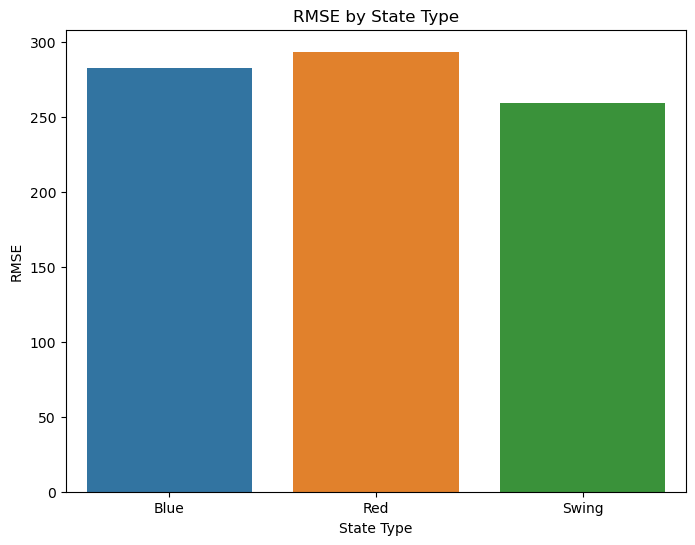

In [16]:
# Evaluate the model on the test set by state type
y_test_blue = y_test[df.loc[y_test.index, 'blue_states'] == 1]
y_test_red = y_test[df.loc[y_test.index, 'red_states'] == 1]
y_test_swing = y_test[df.loc[y_test.index, 'swing_states'] == 1]

X_test_blue = X_test_with_const[df.loc[y_test.index, 'blue_states'] == 1]
X_test_red = X_test_with_const[df.loc[y_test.index, 'red_states'] == 1]
X_test_swing = X_test_with_const[df.loc[y_test.index, 'swing_states'] == 1]

y_pred_blue = model.predict(X_test_blue)
y_pred_red = model.predict(X_test_red)
y_pred_swing = model.predict(X_test_swing)

rmse_blue = np.sqrt(mean_squared_error(y_test_blue, y_pred_blue))
rmse_red = np.sqrt(mean_squared_error(y_test_red, y_pred_red))
rmse_swing = np.sqrt(mean_squared_error(y_test_swing, y_pred_swing))

print(f'RMSE for Blue States: {rmse_blue:.4f}')
print(f'RMSE for Red States: {rmse_red:.4f}')
print(f'RMSE for Swing States: {rmse_swing:.4f}')

# You can also plot these RMSE values for better visualization
rmse_values = pd.DataFrame({
    'State Type': ['Blue', 'Red', 'Swing'],
    'RMSE': [rmse_blue, rmse_red, rmse_swing]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_values)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

**Random Forest with updated data stracture**

R2: 0.5598
Test RMSE: 243.5651
Cross-Validation RMSE: 241.3766 (+/- 16.8934)


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


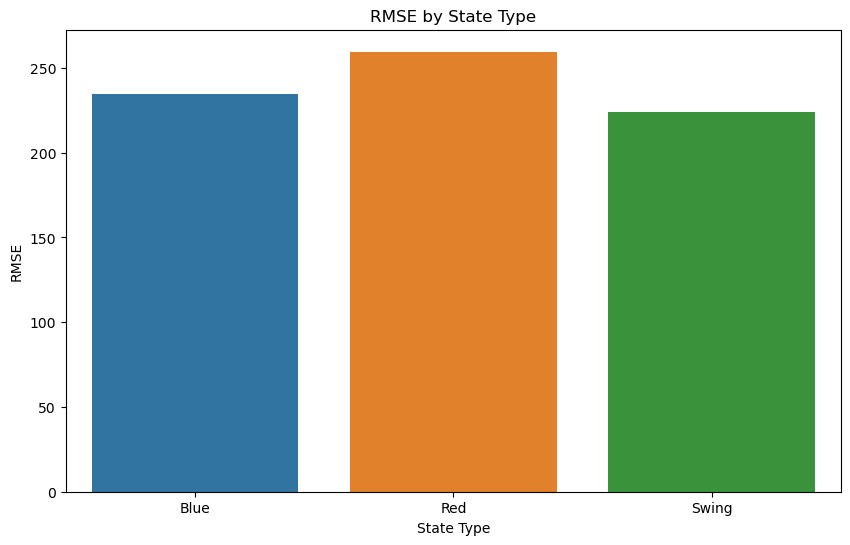

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


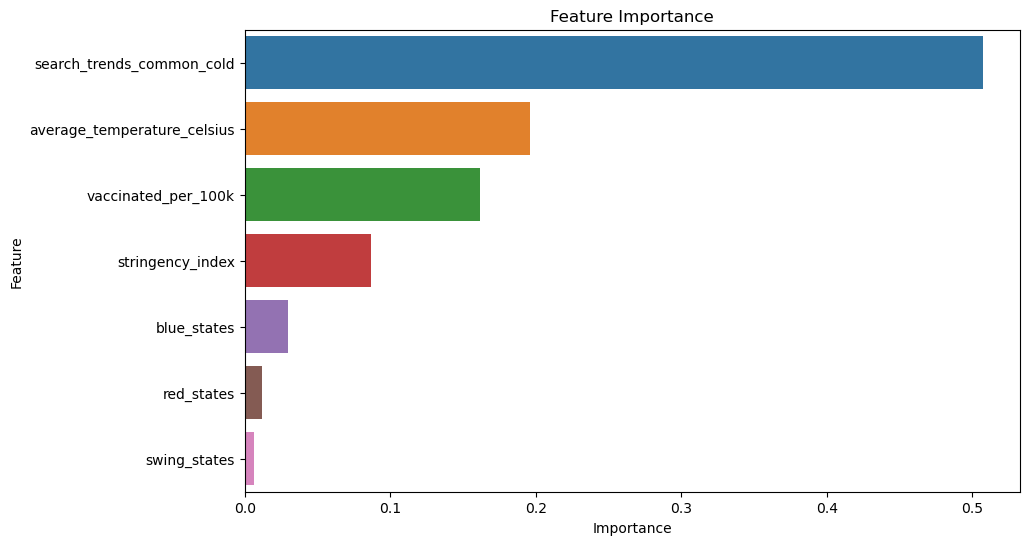

                       Feature  Importance
3    search_trends_common_cold    0.507145
2  average_temperature_celsius    0.196139
0          vaccinated_per_100k    0.161840
1             stringency_index    0.087061
4                  blue_states    0.029852
5                   red_states    0.011505
6                 swing_states    0.006457
Random Forest AIC: 7785.6300
Test MAE: 122.8902


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


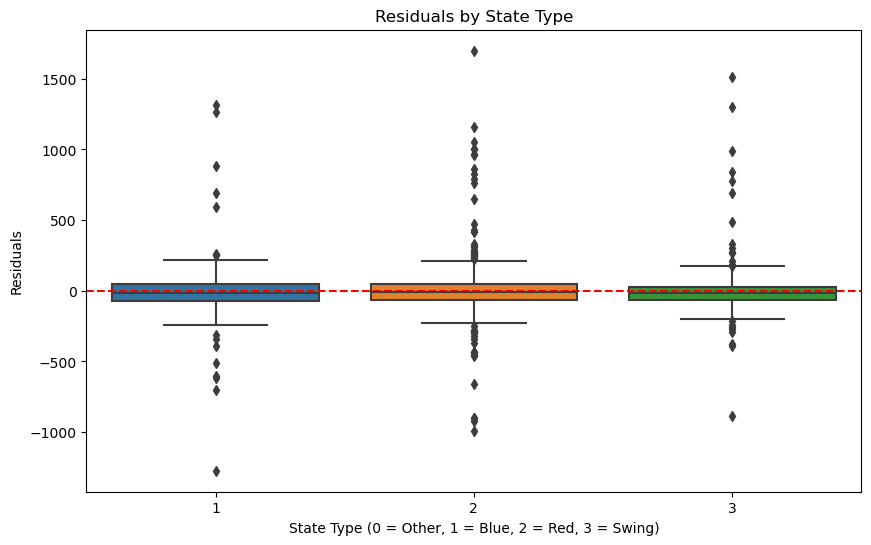

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Select predictors and target variable
X = df[['vaccinated_per_100k', 'stringency_index', 'average_temperature_celsius', 'search_trends_common_cold', 'blue_states', 'red_states', 'swing_states']]
y = df['cases_per_100k']

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')
y_cleaned = y.loc[data_cleaned.index]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cleaned)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cleaned, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# RMSE per state type
y_test_df = pd.DataFrame({'cases_per_100k': y_test, 'blue_states': df.loc[y_test.index, 'blue_states'], 'red_states': df.loc[y_test.index, 'red_states'], 'swing_states': df.loc[y_test.index, 'swing_states']})
y_test_df['predicted'] = y_pred

# Create state type column
def get_state_type(row):
    if row['blue_states'] == 1:
        return 'Blue'
    elif row['red_states'] == 1:
        return 'Red'
    elif row['swing_states'] == 1:
        return 'Swing'
    else:
        return 'Other'

y_test_df['state_type'] = y_test_df.apply(get_state_type, axis=1)

rmse_by_state_type = y_test_df.groupby('state_type').apply(lambda x: np.sqrt(mean_squared_error(x['cases_per_100k'], x['predicted']))).reset_index()
rmse_by_state_type.columns = ['State Type', 'RMSE']

# Plot RMSE by state type
plt.figure(figsize=(10, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_by_state_type)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

# Feature importance
feature_importances = rf_model.feature_importances_
features = data_cleaned.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print feature importance
print(importance_df)

# AIC calculation
n = len(y_test)
rss = np.sum((y_test - y_pred) ** 2)
k_rf = len(rf_model.estimators_) + 1
aic_rf = n * np.log(rss / n) + 2 * k_rf
print(f'Random Forest AIC: {aic_rf:.4f}')

# Additional model evaluation metrics
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae:.4f}')

# Analyze residuals
residuals = y_test - y_pred
results_df = pd.DataFrame({'Residuals': residuals, 'State_Type': df.loc[y_test.index, 'blue_states'] + df.loc[y_test.index, 'red_states']*2 + df.loc[y_test.index, 'swing_states']*3})

plt.figure(figsize=(10, 6))
sns.boxplot(x='State_Type', y='Residuals', data=results_df)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('State Type (0 = Other, 1 = Blue, 2 = Red, 3 = Swing)')
plt.ylabel('Residuals')
plt.title('Residuals by State Type')
plt.show()

**XGbooster**

R2: 0.5252
Test RMSE: 252.9626
Cross-Validation RMSE: 259.1938 (+/- 16.4622)


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


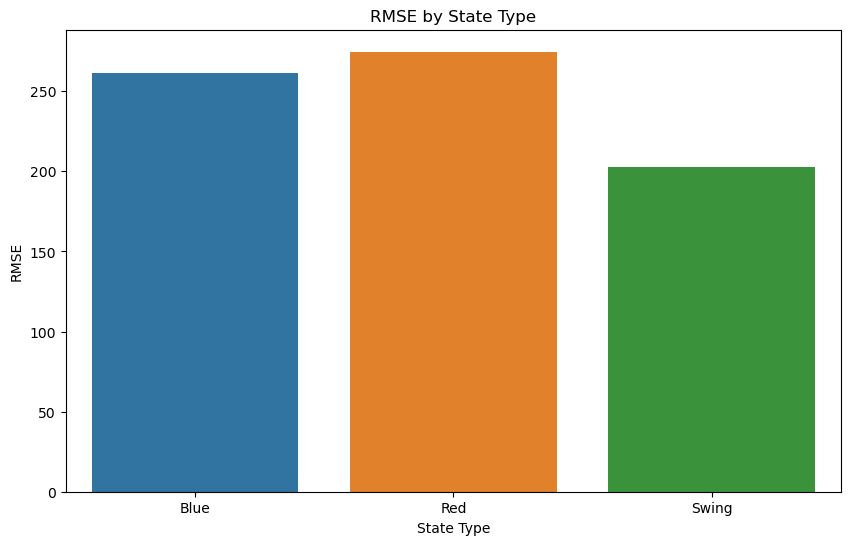

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


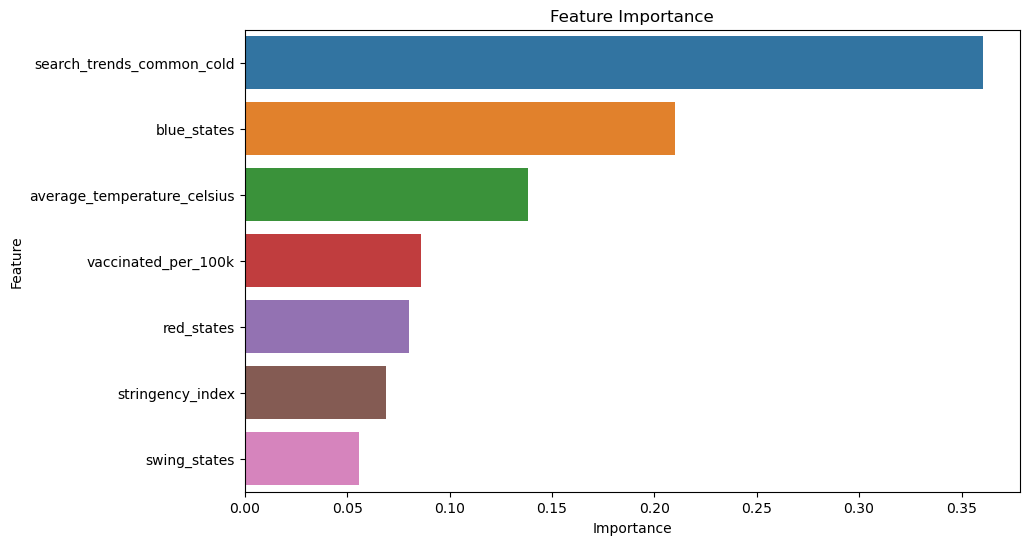

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


                       Feature  Importance
3    search_trends_common_cold    0.360433
4                  blue_states    0.210253
2  average_temperature_celsius    0.138361
0          vaccinated_per_100k    0.085958
5                   red_states    0.080194
1             stringency_index    0.068923
6                 swing_states    0.055878
XGBoost AIC: 7837.8737
Test MAE: 123.8985


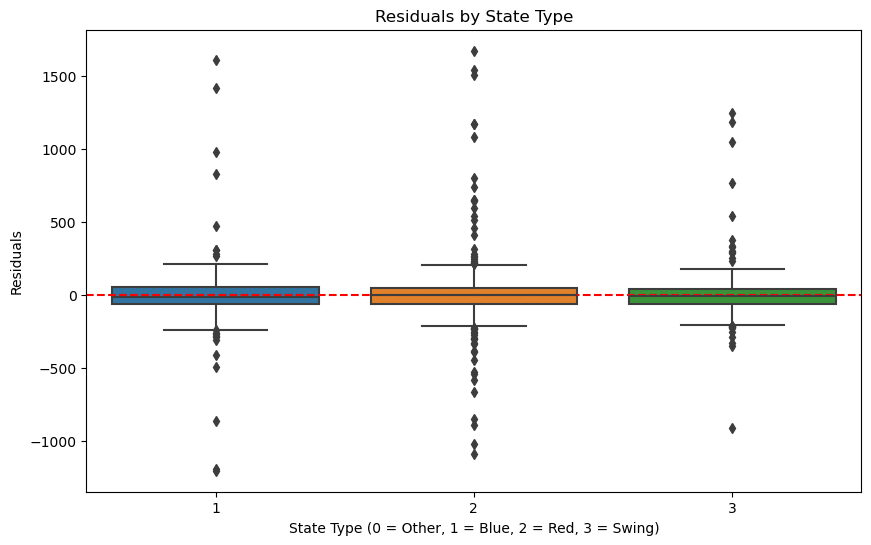

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Load the data
df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Select predictors and target variable
X = df[['vaccinated_per_100k', 'stringency_index', 'average_temperature_celsius', 'search_trends_common_cold', 'blue_states', 'red_states', 'swing_states']]
y = df['cases_per_100k']

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')
y_cleaned = y.loc[data_cleaned.index]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cleaned)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cleaned, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgboost_model = xgb.XGBRegressor(random_state=42)
xgboost_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgboost_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# RMSE per state type
y_test_df = pd.DataFrame({'cases_per_100k': y_test, 'blue_states': df.loc[y_test.index, 'blue_states'], 'red_states': df.loc[y_test.index, 'red_states'], 'swing_states': df.loc[y_test.index, 'swing_states']})
y_test_df['predicted'] = y_pred

# Create state type column
def get_state_type(row):
    if row['blue_states'] == 1:
        return 'Blue'
    elif row['red_states'] == 1:
        return 'Red'
    elif row['swing_states'] == 1:
        return 'Swing'
    else:
        return 'Other'

y_test_df['state_type'] = y_test_df.apply(get_state_type, axis=1)

rmse_by_state_type = y_test_df.groupby('state_type').apply(lambda x: np.sqrt(mean_squared_error(x['cases_per_100k'], x['predicted']))).reset_index()
rmse_by_state_type.columns = ['State Type', 'RMSE']

# Plot RMSE by state type
plt.figure(figsize=(10, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_by_state_type)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

# Feature importance
feature_importances = xgboost_model.feature_importances_
features = data_cleaned.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print feature importance
print(importance_df)

# AIC

y_pred_xgb = xgboost_model.predict(X_test)
rss_xgb = np.sum((y_test - y_pred_xgb) ** 2)
k_xgb = len(xgboost_model.get_booster().get_dump()) + 1
aic_xgb = n * np.log(rss_xgb / n) + 2 * k_xgb
print(f'XGBoost AIC: {aic_xgb:.4f}')

test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae:.4f}')

# Analyze residuals
residuals = y_test - y_pred
results_df = pd.DataFrame({'Residuals': residuals, 'State_Type': df.loc[y_test.index, 'blue_states'] + df.loc[y_test.index, 'red_states']*2 + df.loc[y_test.index, 'swing_states']*3})

plt.figure(figsize=(10, 6))
sns.boxplot(x='State_Type', y='Residuals', data=results_df)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('State Type (0 = Other, 1 = Blue, 2 = Red, 3 = Swing)')
plt.ylabel('Residuals')
plt.title('Residuals by State Type')
plt.show()

**Random Forest may be the best model in our case**

R2: 0.5598
Test RMSE: 243.5651
Cross-Validation RMSE: 241.3766 (+/- 16.8934)


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


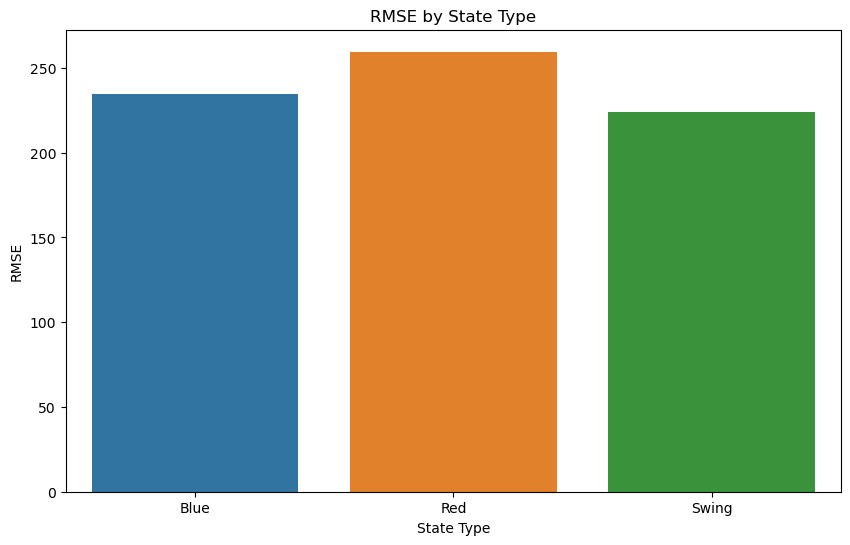

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


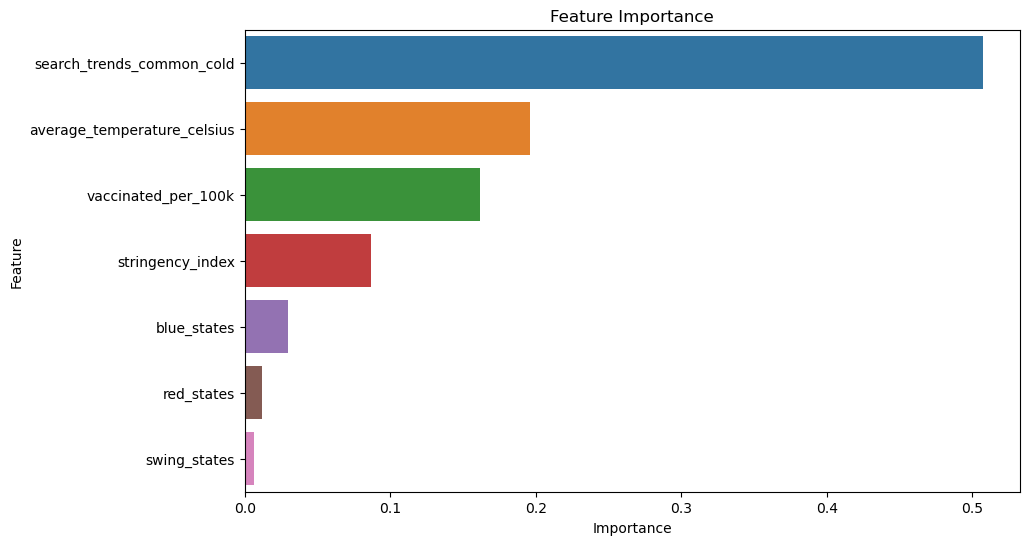

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


                       Feature  Importance
3    search_trends_common_cold    0.507145
2  average_temperature_celsius    0.196139
0          vaccinated_per_100k    0.161840
1             stringency_index    0.087061
4                  blue_states    0.029852
5                   red_states    0.011505
6                 swing_states    0.006457
Random Forest AIC: 7785.6300
Test MAE: 122.8902


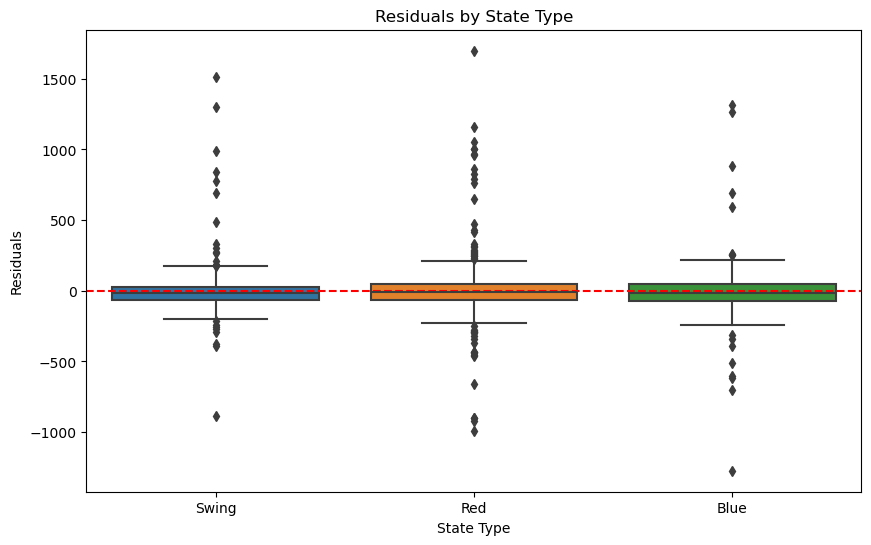

ANOVA F-value: 0.3675, p-value: 0.6926

Demographic Parity:
  State Type  Mean Predicted Value
0       Blue            247.422083
1        Red            273.109793
2      Swing            230.309361

Equalized Odds (Residuals):
  State_Type  Mean Residual  Std Residual
0       Blue      -7.011380     234.54616
1        Red      11.216984     259.31789
2      Swing      10.853222     223.66828

Predictive Parity (Mean Absolute Error):
  State Type         MAE
0       Blue  120.551232
1        Red  134.304007
2      Swing  106.395943

Data Points Count by State Type:
  State Type  Counts
0        Red    2507
1      Swing    1526
2       Blue    1417


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load the data
df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Create a state_type column
def get_state_type(row):
    if row['blue_states'] == 1:
        return 'Blue'
    elif row['red_states'] == 1:
        return 'Red'
    elif row['swing_states'] == 1:
        return 'Swing'
    else:
        return 'Other'

df['state_type'] = df.apply(get_state_type, axis=1)

# Select predictors and target variable
X = df[['vaccinated_per_100k', 'stringency_index', 'average_temperature_celsius', 'search_trends_common_cold', 'blue_states', 'red_states', 'swing_states']]
y = df['cases_per_100k']

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')
y_cleaned = y.loc[data_cleaned.index]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cleaned)

# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cleaned, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# RMSE per state type
y_test_df = pd.DataFrame({'cases_per_100k': y_test, 'blue_states': df.loc[y_test.index, 'blue_states'], 'red_states': df.loc[y_test.index, 'red_states'], 'swing_states': df.loc[y_test.index, 'swing_states']})
y_test_df['predicted'] = y_pred

# Create state type column
y_test_df['state_type'] = y_test_df.apply(get_state_type, axis=1)

rmse_by_state_type = y_test_df.groupby('state_type').apply(lambda x: np.sqrt(mean_squared_error(x['cases_per_100k'], x['predicted']))).reset_index()
rmse_by_state_type.columns = ['State Type', 'RMSE']

# Plot RMSE by state type
plt.figure(figsize=(10, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_by_state_type)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

# Feature importance
feature_importances = rf_model.feature_importances_
features = data_cleaned.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print feature importance
print(importance_df)

# AIC calculation
n = len(y_test)
rss = np.sum((y_test - y_pred) ** 2)
k_rf = len(rf_model.estimators_) + 1
aic_rf = n * np.log(rss / n) + 2 * k_rf
print(f'Random Forest AIC: {aic_rf:.4f}')

# Additional model evaluation metrics
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae:.4f}')

# Analyze residuals
residuals = y_test - y_pred
results_df = pd.DataFrame({'Residuals': residuals, 'State_Type': y_test_df['state_type']})

plt.figure(figsize=(10, 6))
sns.boxplot(x='State_Type', y='Residuals', data=results_df)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('State Type')
plt.ylabel('Residuals')
plt.title('Residuals by State Type')
plt.show()

# Statistical Tests
# ANOVA test for residuals by state type
anova_results = stats.f_oneway(
    results_df[results_df['State_Type'] == 'Blue']['Residuals'],
    results_df[results_df['State_Type'] == 'Red']['Residuals'],
    results_df[results_df['State_Type'] == 'Swing']['Residuals']
)
print(f'ANOVA F-value: {anova_results.statistic:.4f}, p-value: {anova_results.pvalue:.4f}')

# Fairness Metrics
# Demographic Parity
demographic_parity = y_test_df.groupby('state_type')['predicted'].mean().reset_index()
demographic_parity.columns = ['State Type', 'Mean Predicted Value']
print("\nDemographic Parity:")
print(demographic_parity)

# Equalized Odds (Residuals)
residuals_by_state_type = results_df.groupby('State_Type')['Residuals'].apply(list).reset_index()
residuals_by_state_type['Mean Residual'] = residuals_by_state_type['Residuals'].apply(np.mean)
residuals_by_state_type['Std Residual'] = residuals_by_state_type['Residuals'].apply(np.std)
print("\nEqualized Odds (Residuals):")
print(residuals_by_state_type[['State_Type', 'Mean Residual', 'Std Residual']])

# Predictive Parity (Mean Absolute Error)
mae_by_state_type = y_test_df.groupby('state_type').apply(lambda x: mean_absolute_error(x['cases_per_100k'], x['predicted'])).reset_index()
mae_by_state_type.columns = ['State Type', 'MAE']
print("\nPredictive Parity (Mean Absolute Error):")
print(mae_by_state_type)

# Count data points for each state type
data_points_count = df['state_type'].value_counts().reset_index()
data_points_count.columns = ['State Type', 'Counts']
print("\nData Points Count by State Type:")
print(data_points_count)